In [1]:
!pip install pandas-datareader
!pip install yfinance

In [18]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
from datetime import datetime
import os
import yfinance as yf
yf.pdr_override()
import statsmodels
from statsmodels.tsa.stattools import coint

In [20]:
final_companies = pd.read_csv('final_stocks_data.csv')
final_companies_nd = final_companies.drop_duplicates(subset ="Symbl",
                     keep = 'first', inplace= False)
final_companies_nd.reset_index(inplace=True)
del final_companies_nd['index']
final_companies_nd

Symbl
0     HCLTECH.NS
1    DIVISLAB.NS
2        ATGL.NS
3    MINDTREE.NS
4        INFY.NS
5  TATACONSUM.NS
6  ADANITRANS.NS
7         TCS.NS
8     MPHASIS.NS

In [21]:
start = datetime(2018,11,5)
end = datetime(2022,2,1)

In [22]:
#This function returns a pd dataframe with all of the adjusted closing information
def get_historical_Data(tickers):
    data = pd.DataFrame()
    names = list()
    for i in tickers:
        data = pd.concat([data, pd.DataFrame(yf.download(i, start=start, end=end).iloc[:,4])], axis = 1)
        names.append(i)
    data.columns = names
    print(names)
    return data

ticks = final_companies_nd['Symbl'].tolist()
d = get_historical_Data(ticks)
print(d.shape)
d.tail()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
['HCLTECH.NS', 'DIVISLAB.NS', 'ATGL.NS', 'MINDTREE.NS', 'INFY.NS', 'TATACONSUM.NS', 'ADANITRANS.NS', 'TCS.NS', 'MPHASIS.NS']
(800, 9)


HCLTECH.NS  DIVISLAB.NS      ATGL.NS  MINDTREE.NS      INFY.NS  \
Date                                                                          
2022-01-24  1124.900024  4056.600098  1781.150024  3888.949951  1736.800049   
2022-01-25  1123.699951  4049.199951  1825.199951  3827.199951  1722.150024   
2022-01-27  1077.750000  3939.850098  1830.750000  3585.199951  1678.599976   
2022-01-28  1080.449951  3940.699951  1830.900024  3724.199951  1686.199951   
2022-01-31  1099.400024  4036.100098  1821.250000  4006.300049  1736.199951   

            TATACONSUM.NS  ADANITRANS.NS       TCS.NS   MPHASIS.NS  
Date                                                                
2022-01-24     691.450012    2035.900024  3771.350098  2947.350098  
2022-01-25     707.750000    1992.449951  3769.899902  3062.250000  
2022-01-27     705.950012    2009.300049  3649.250000  2934.000000  
2022-01-28     717.900024    1986.800049  3690.050049  3039.300049  
2022-01-31     727.299988    1970.900024  3736.250000  3106.500000

In [23]:
d

HCLTECH.NS  DIVISLAB.NS      ATGL.NS  MINDTREE.NS      INFY.NS  \
Date                                                                          
2018-11-05   481.308990  1434.431641    75.243607   755.219238   610.962585   
2018-11-06   485.151947  1445.533936    77.731819   766.935608   611.375366   
2018-11-07   486.401459  1464.803833    80.916740   768.773376   619.677490   
2018-11-09   484.680359  1515.130493    79.573097   785.038391   604.999634   
2018-11-12   488.876984  1478.742676    75.641724   793.400696   609.311279   
...                 ...          ...          ...          ...          ...   
2022-01-24  1124.900024  4056.600098  1781.150024  3888.949951  1736.800049   
2022-01-25  1123.699951  4049.199951  1825.199951  3827.199951  1722.150024   
2022-01-27  1077.750000  3939.850098  1830.750000  3585.199951  1678.599976   
2022-01-28  1080.449951  3940.699951  1830.900024  3724.199951  1686.199951   
2022-01-31  1099.400024  4036.100098  1821.250000  4006.300049  1736.199951   

            TATACONSUM.NS  ADANITRANS.NS       TCS.NS   MPHASIS.NS  
Date                                                                
2018-11-05     214.630905     182.250000  1773.829346   870.589905  
2018-11-06     208.724518     178.600006  1813.089111   841.331360  
2018-11-07     210.091293     179.199997  1821.954224   859.265564  
2018-11-09     204.526596     176.300003  1791.043579   876.367676  
2018-11-12     209.603149     171.750000  1796.343994   897.259949  
...                   ...            ...          ...          ...  
2022-01-24     691.450012    2035.900024  3771.350098  2947.350098  
2022-01-25     707.750000    1992.449951  3769.899902  3062.250000  
2022-01-27     705.950012    2009.300049  3649.250000  2934.000000  
2022-01-28     717.900024    1986.800049  3690.050049  3039.300049  
2022-01-31     727.299988    1970.900024  3736.250000  3106.500000  

[800 rows x 9 columns]

In [24]:
# creating a function to find cointegrated pairs among the 10 companies sorted above
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

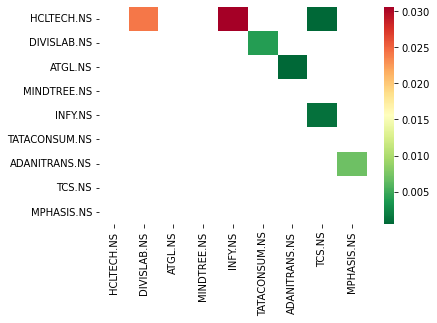

[('HCLTECH.NS', 'DIVISLAB.NS'), ('HCLTECH.NS', 'INFY.NS'), ('HCLTECH.NS', 'TCS.NS'), ('DIVISLAB.NS', 'TATACONSUM.NS'), ('ATGL.NS', 'ADANITRANS.NS'), ('INFY.NS', 'TCS.NS'), ('ADANITRANS.NS', 'MPHASIS.NS')]
7


In [27]:
# Heatmap to show the p-values of the cointegration test between each pair of stocks
scores, pvalues, pairs = find_cointegrated_pairs(d)
import seaborn

names = final_companies_nd['Symbl'].tolist()
m = np.arange(0, 1, 0.05).tolist()
seaborn.heatmap(pvalues, xticklabels=names, 
                yticklabels=names, cmap='RdYlGn_r' 
                , mask = (pvalues >= 0.05))
plt.show()
print(pairs)
print(len(pairs))

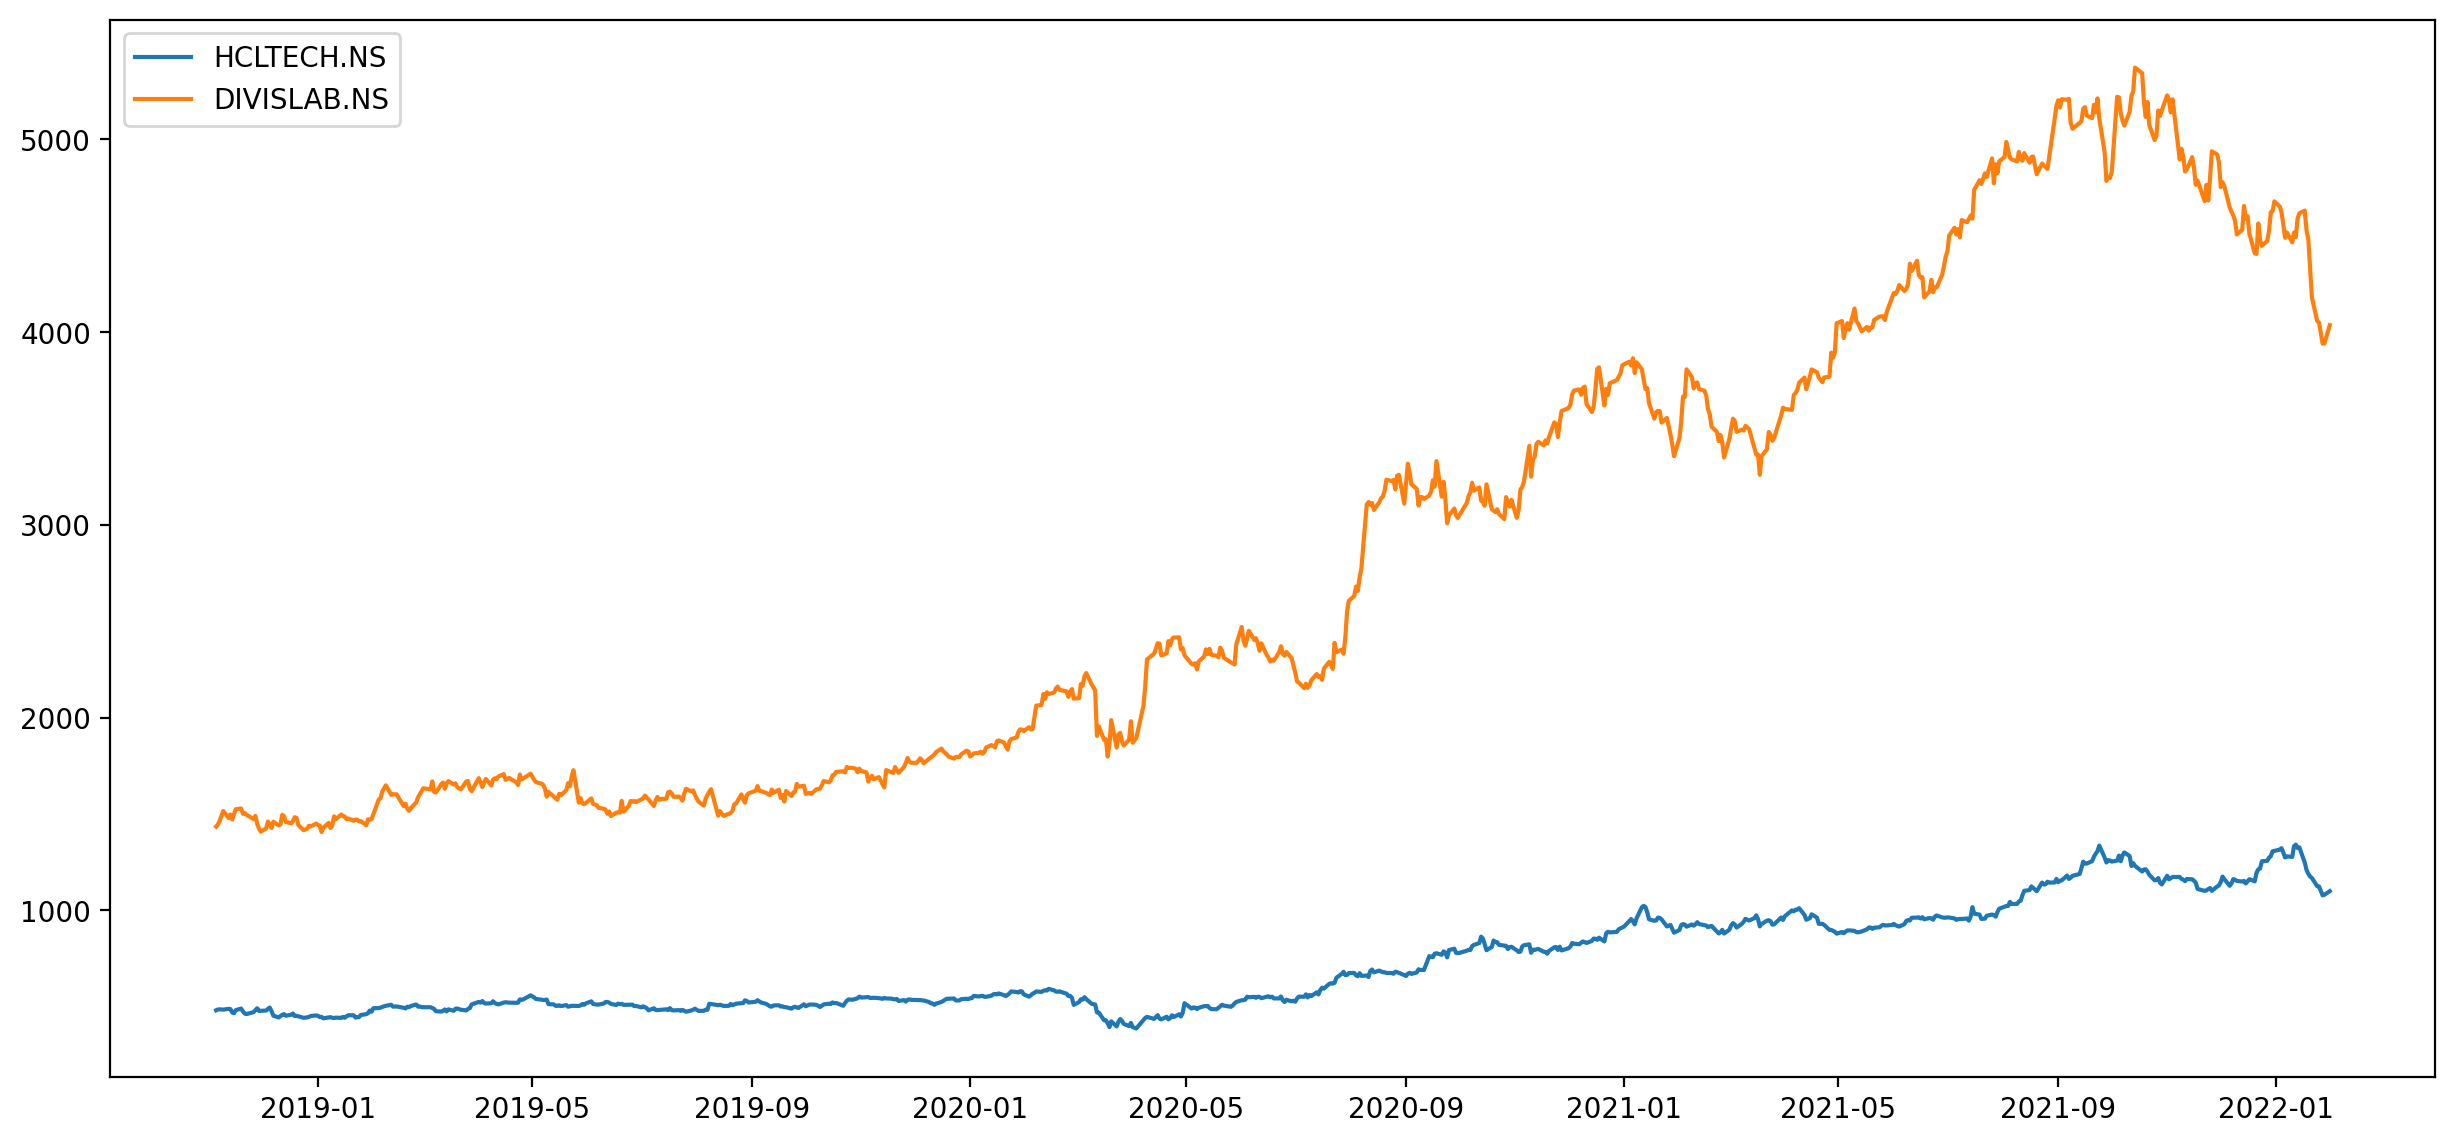

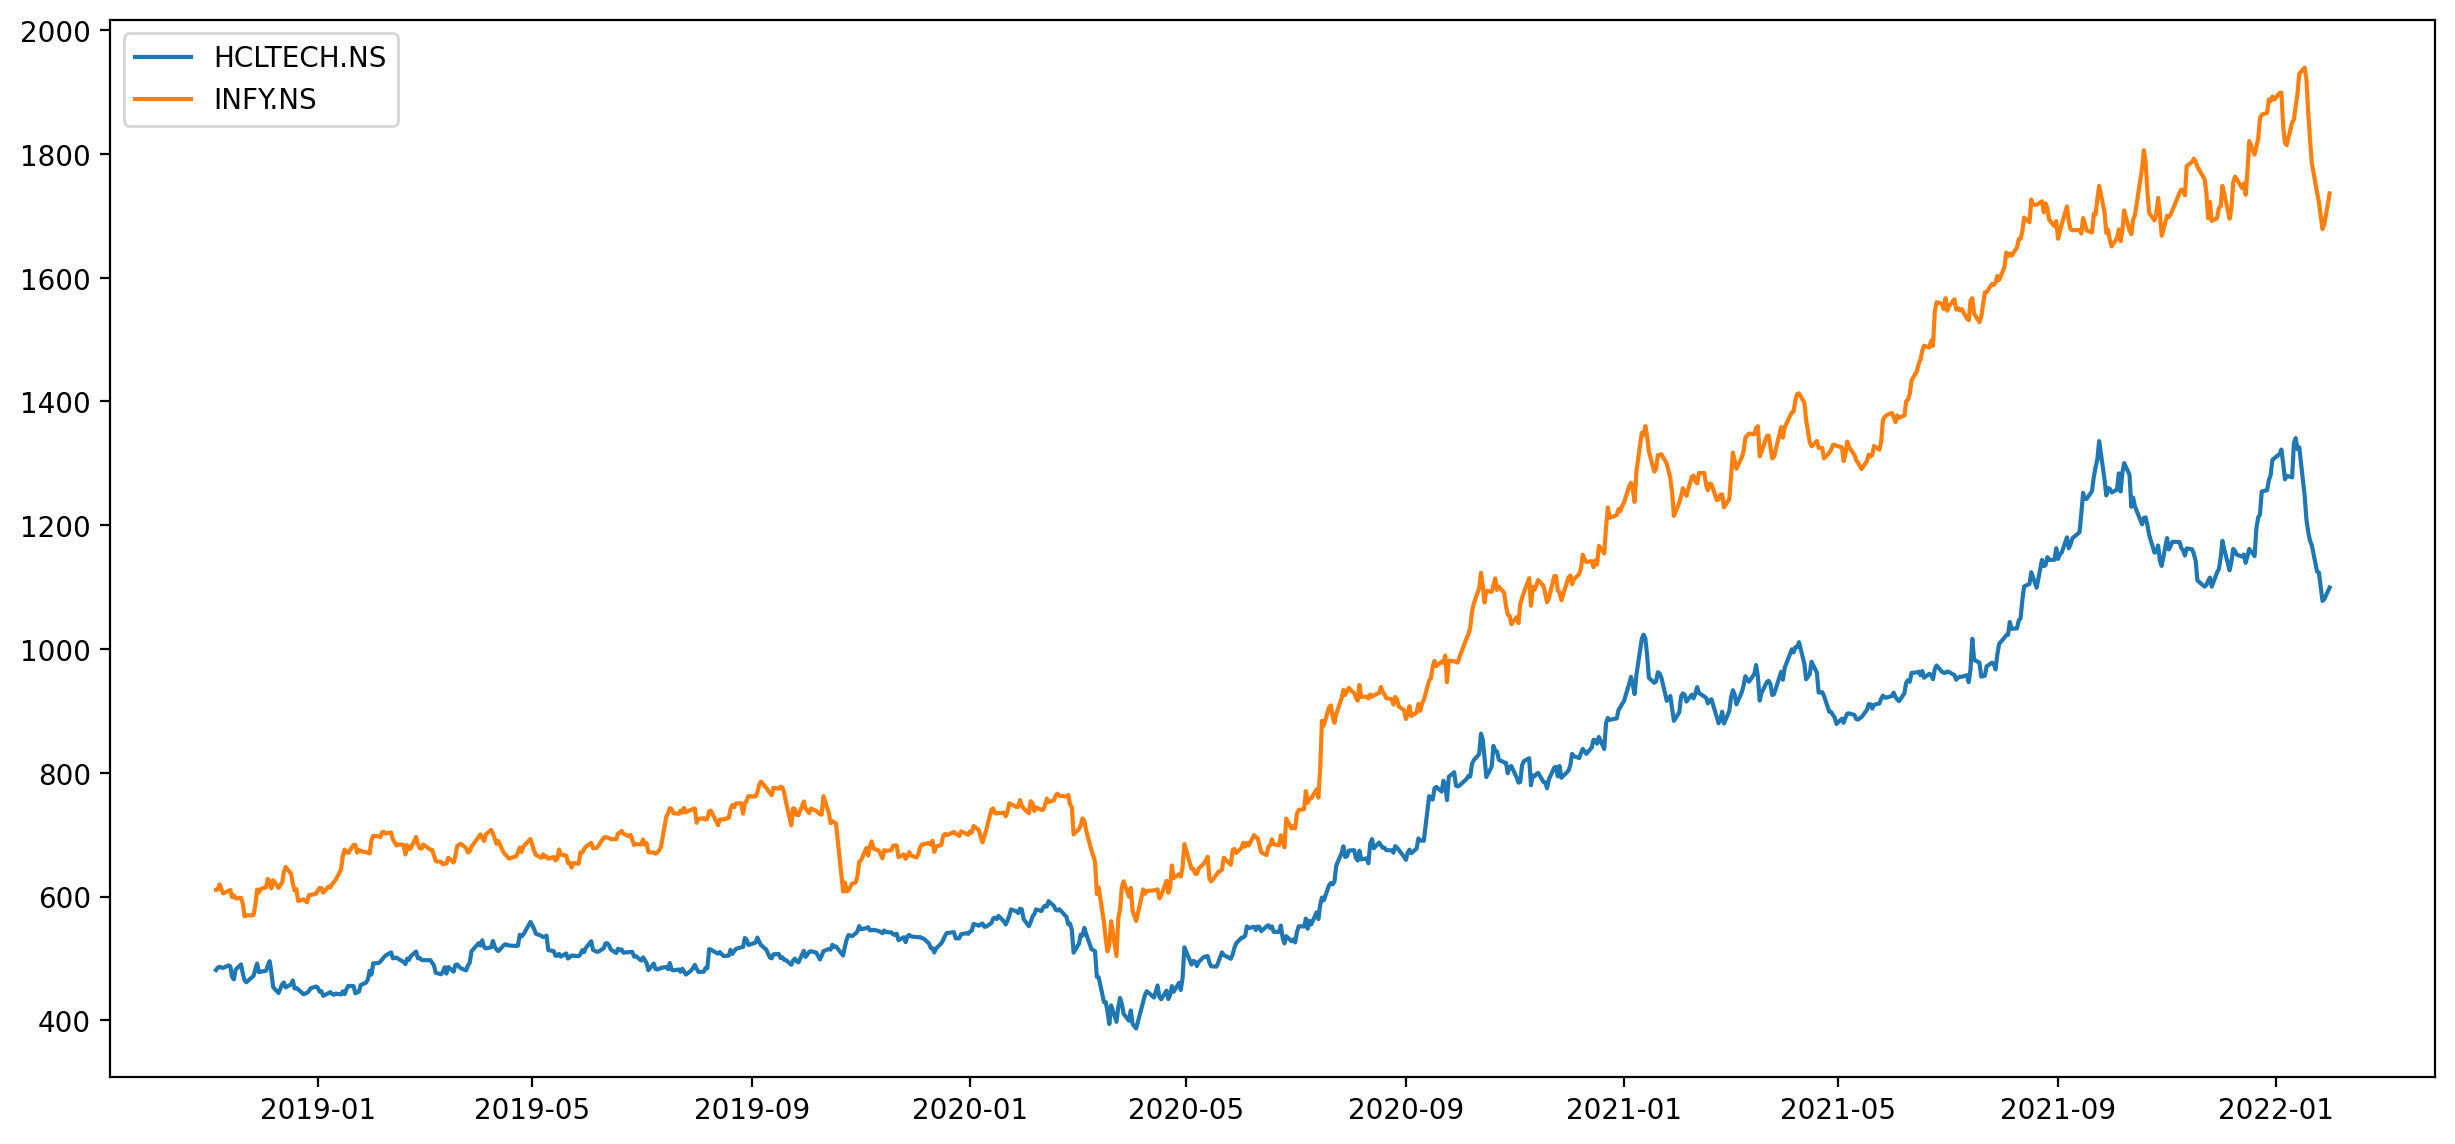

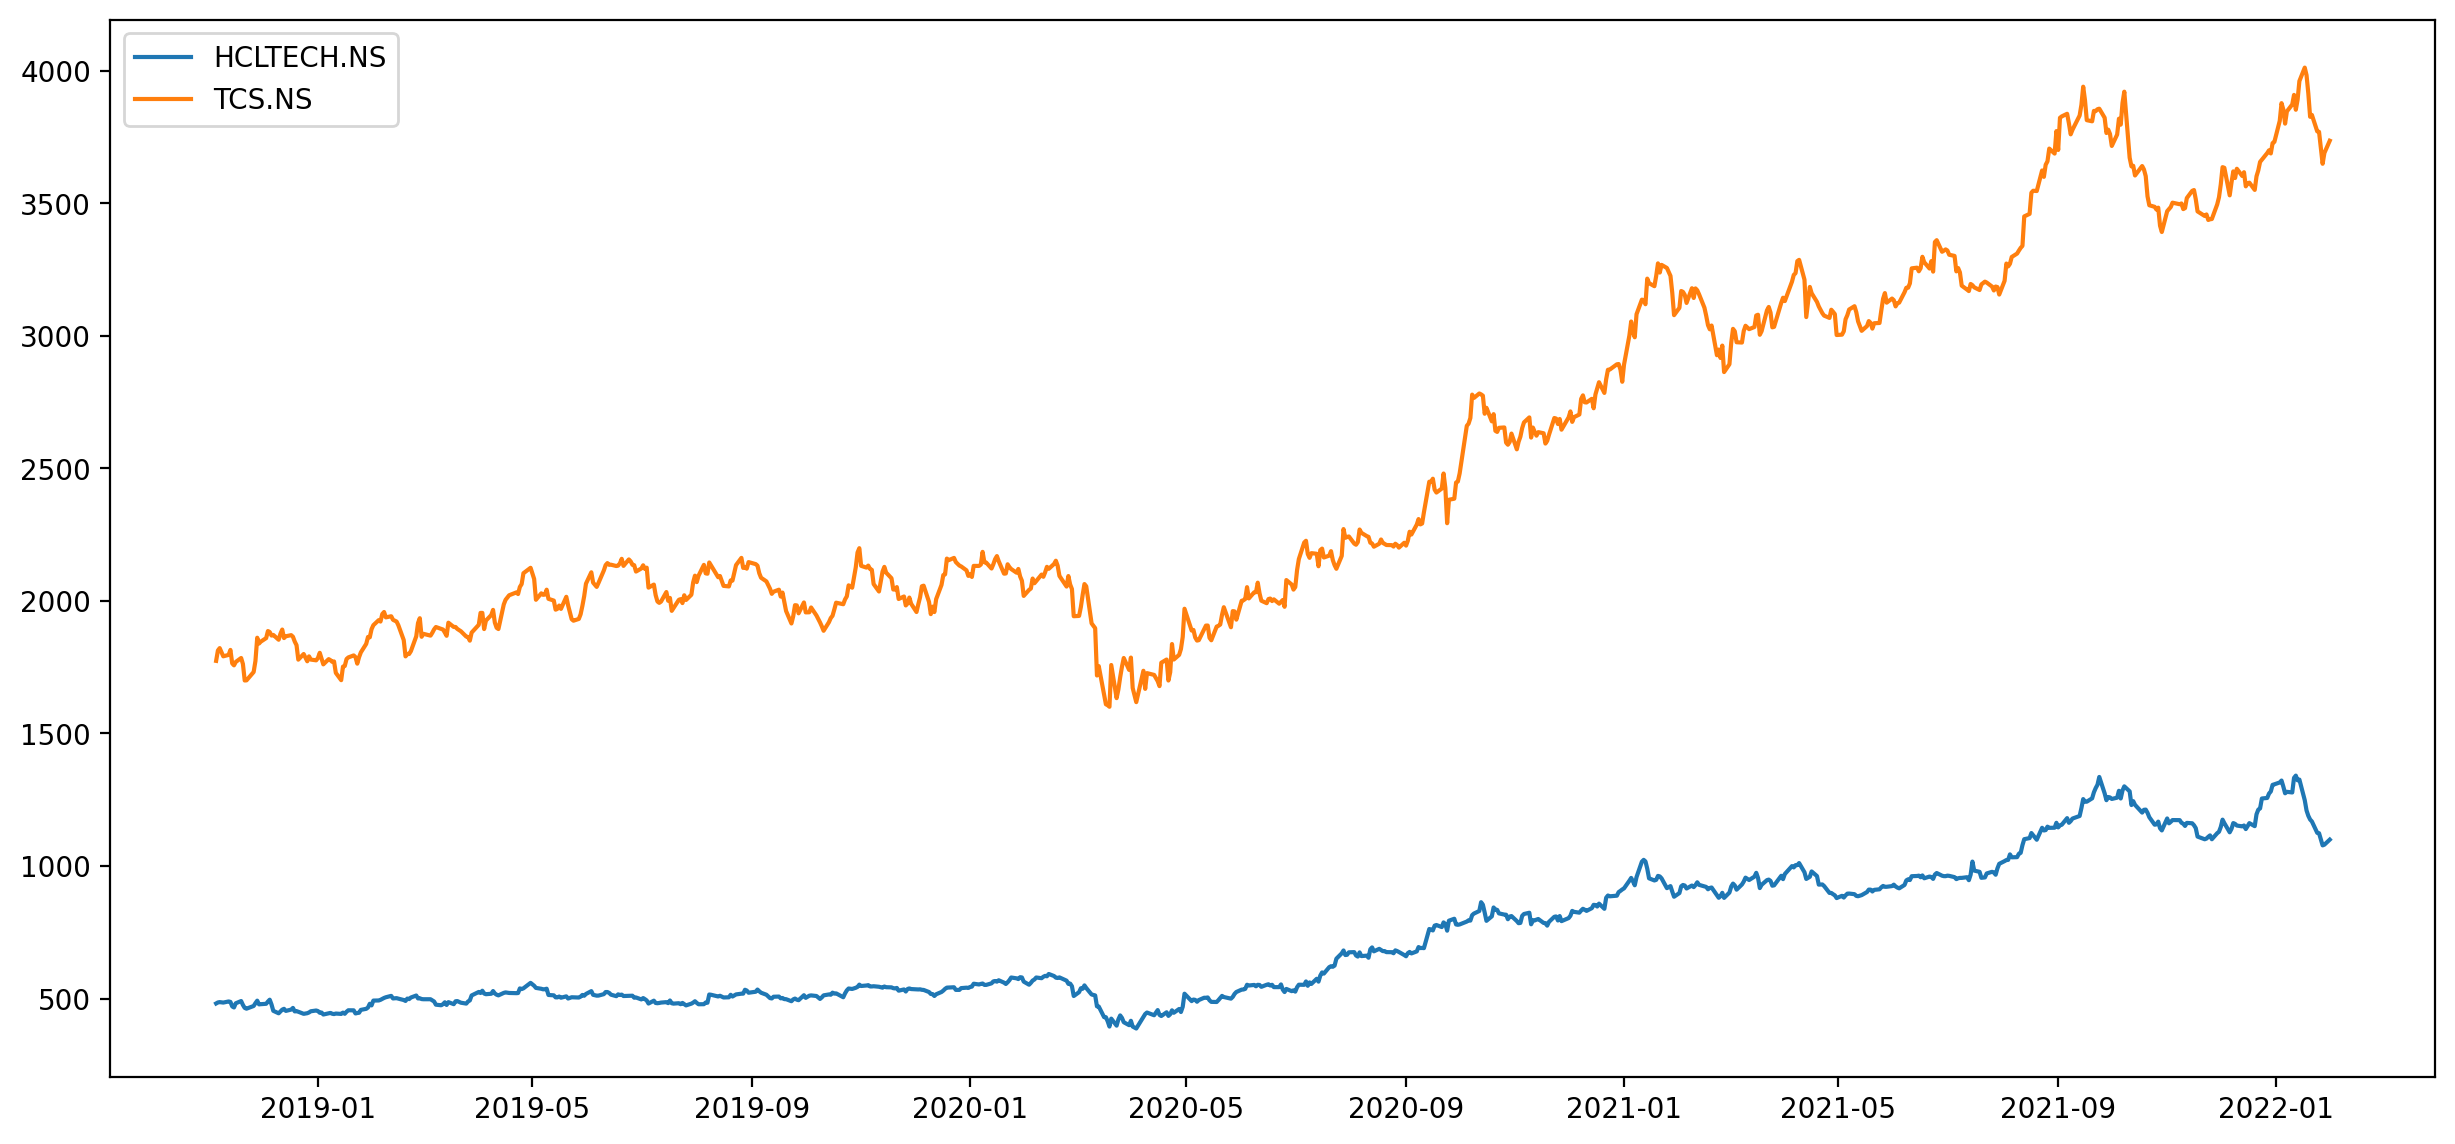

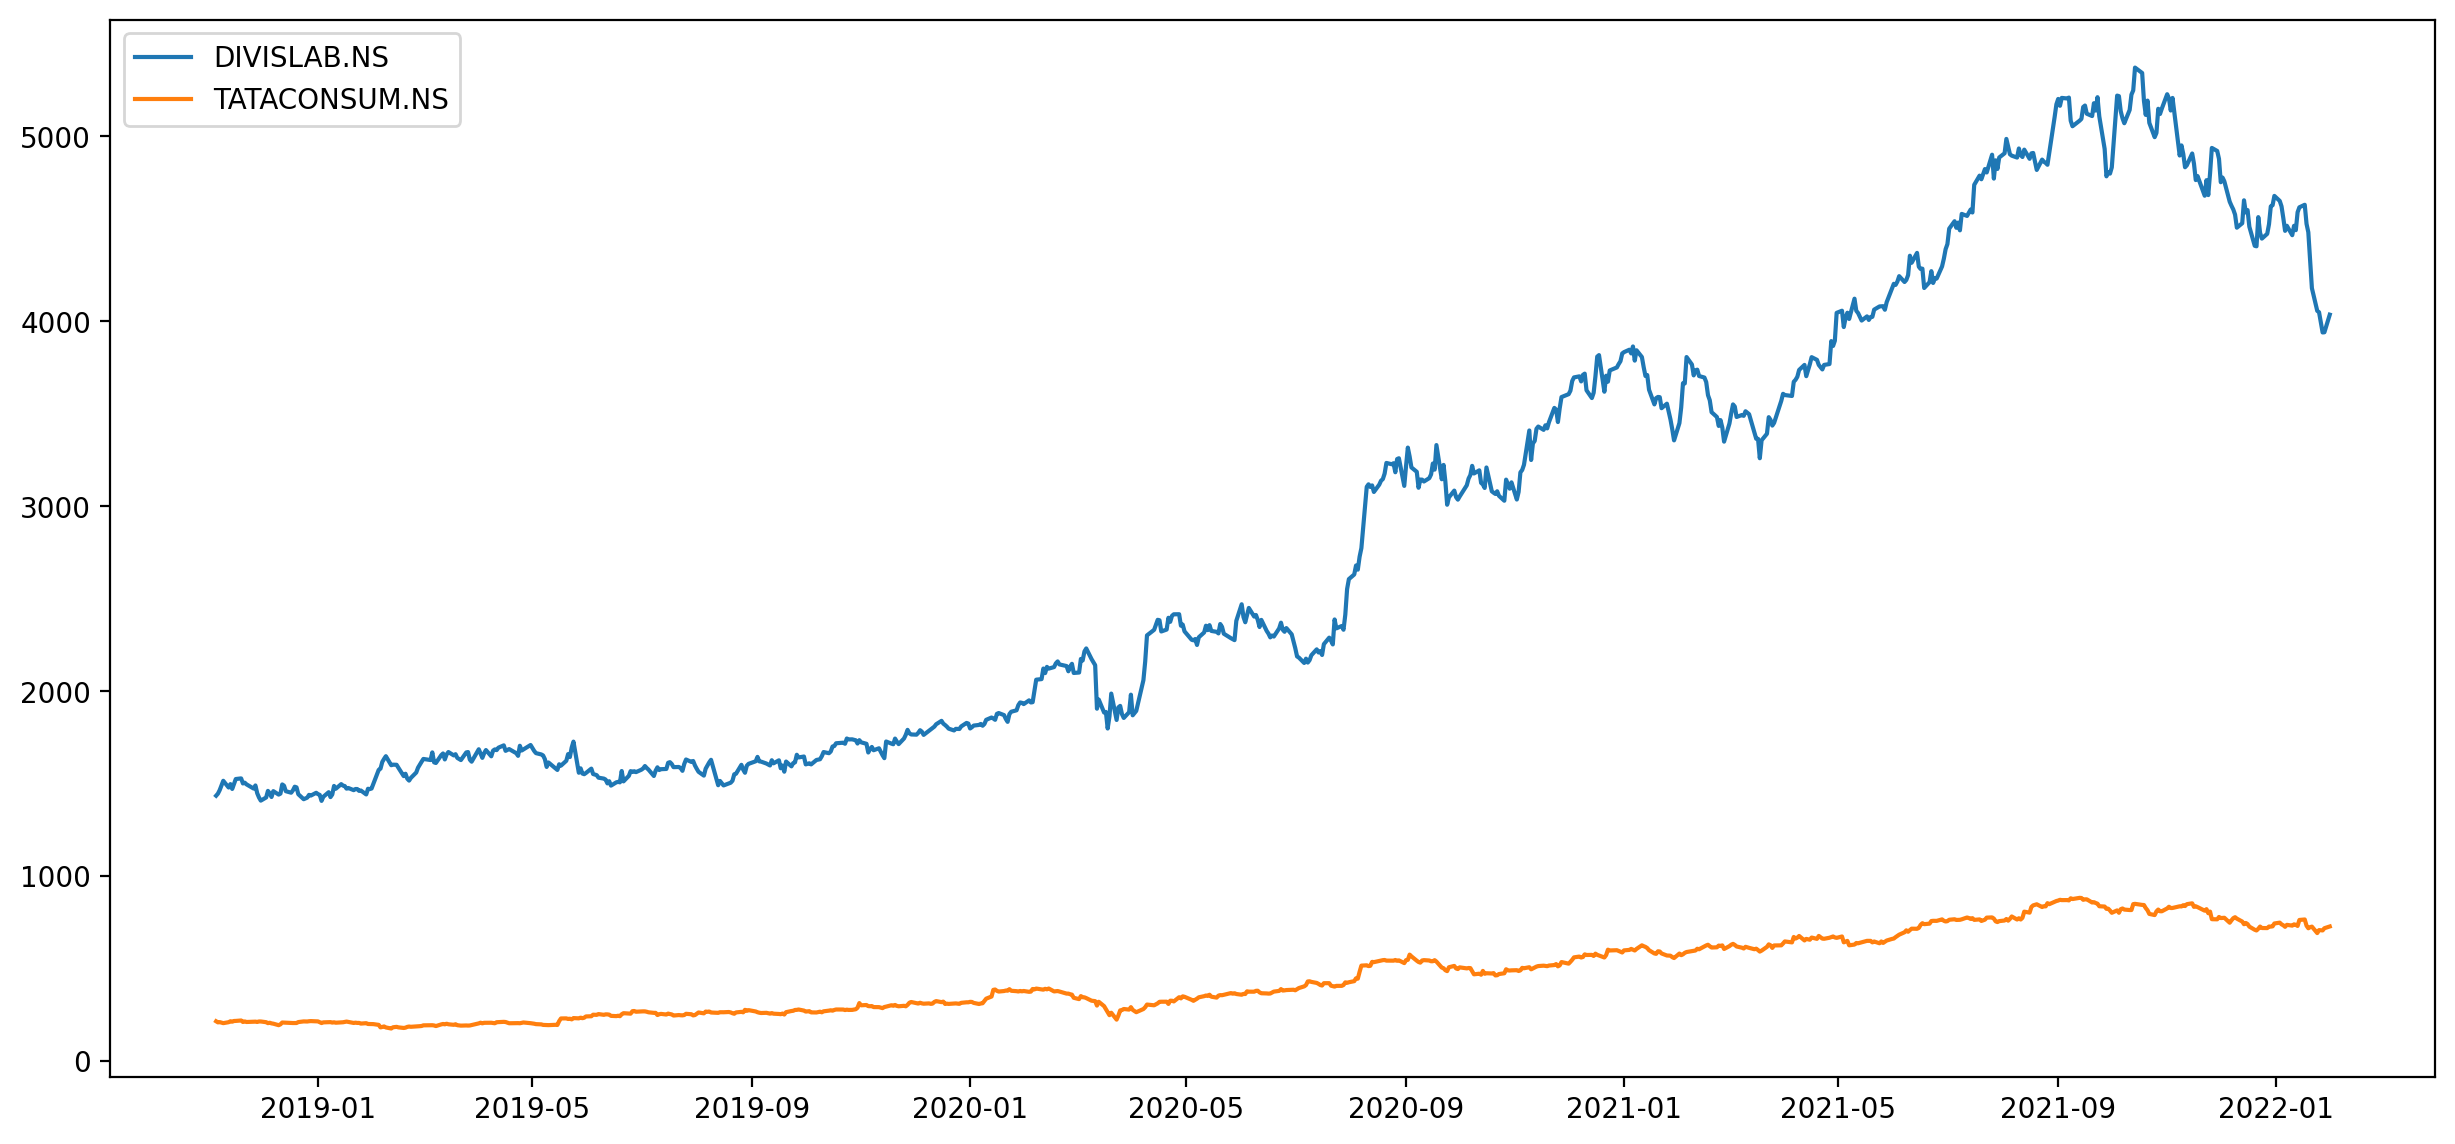

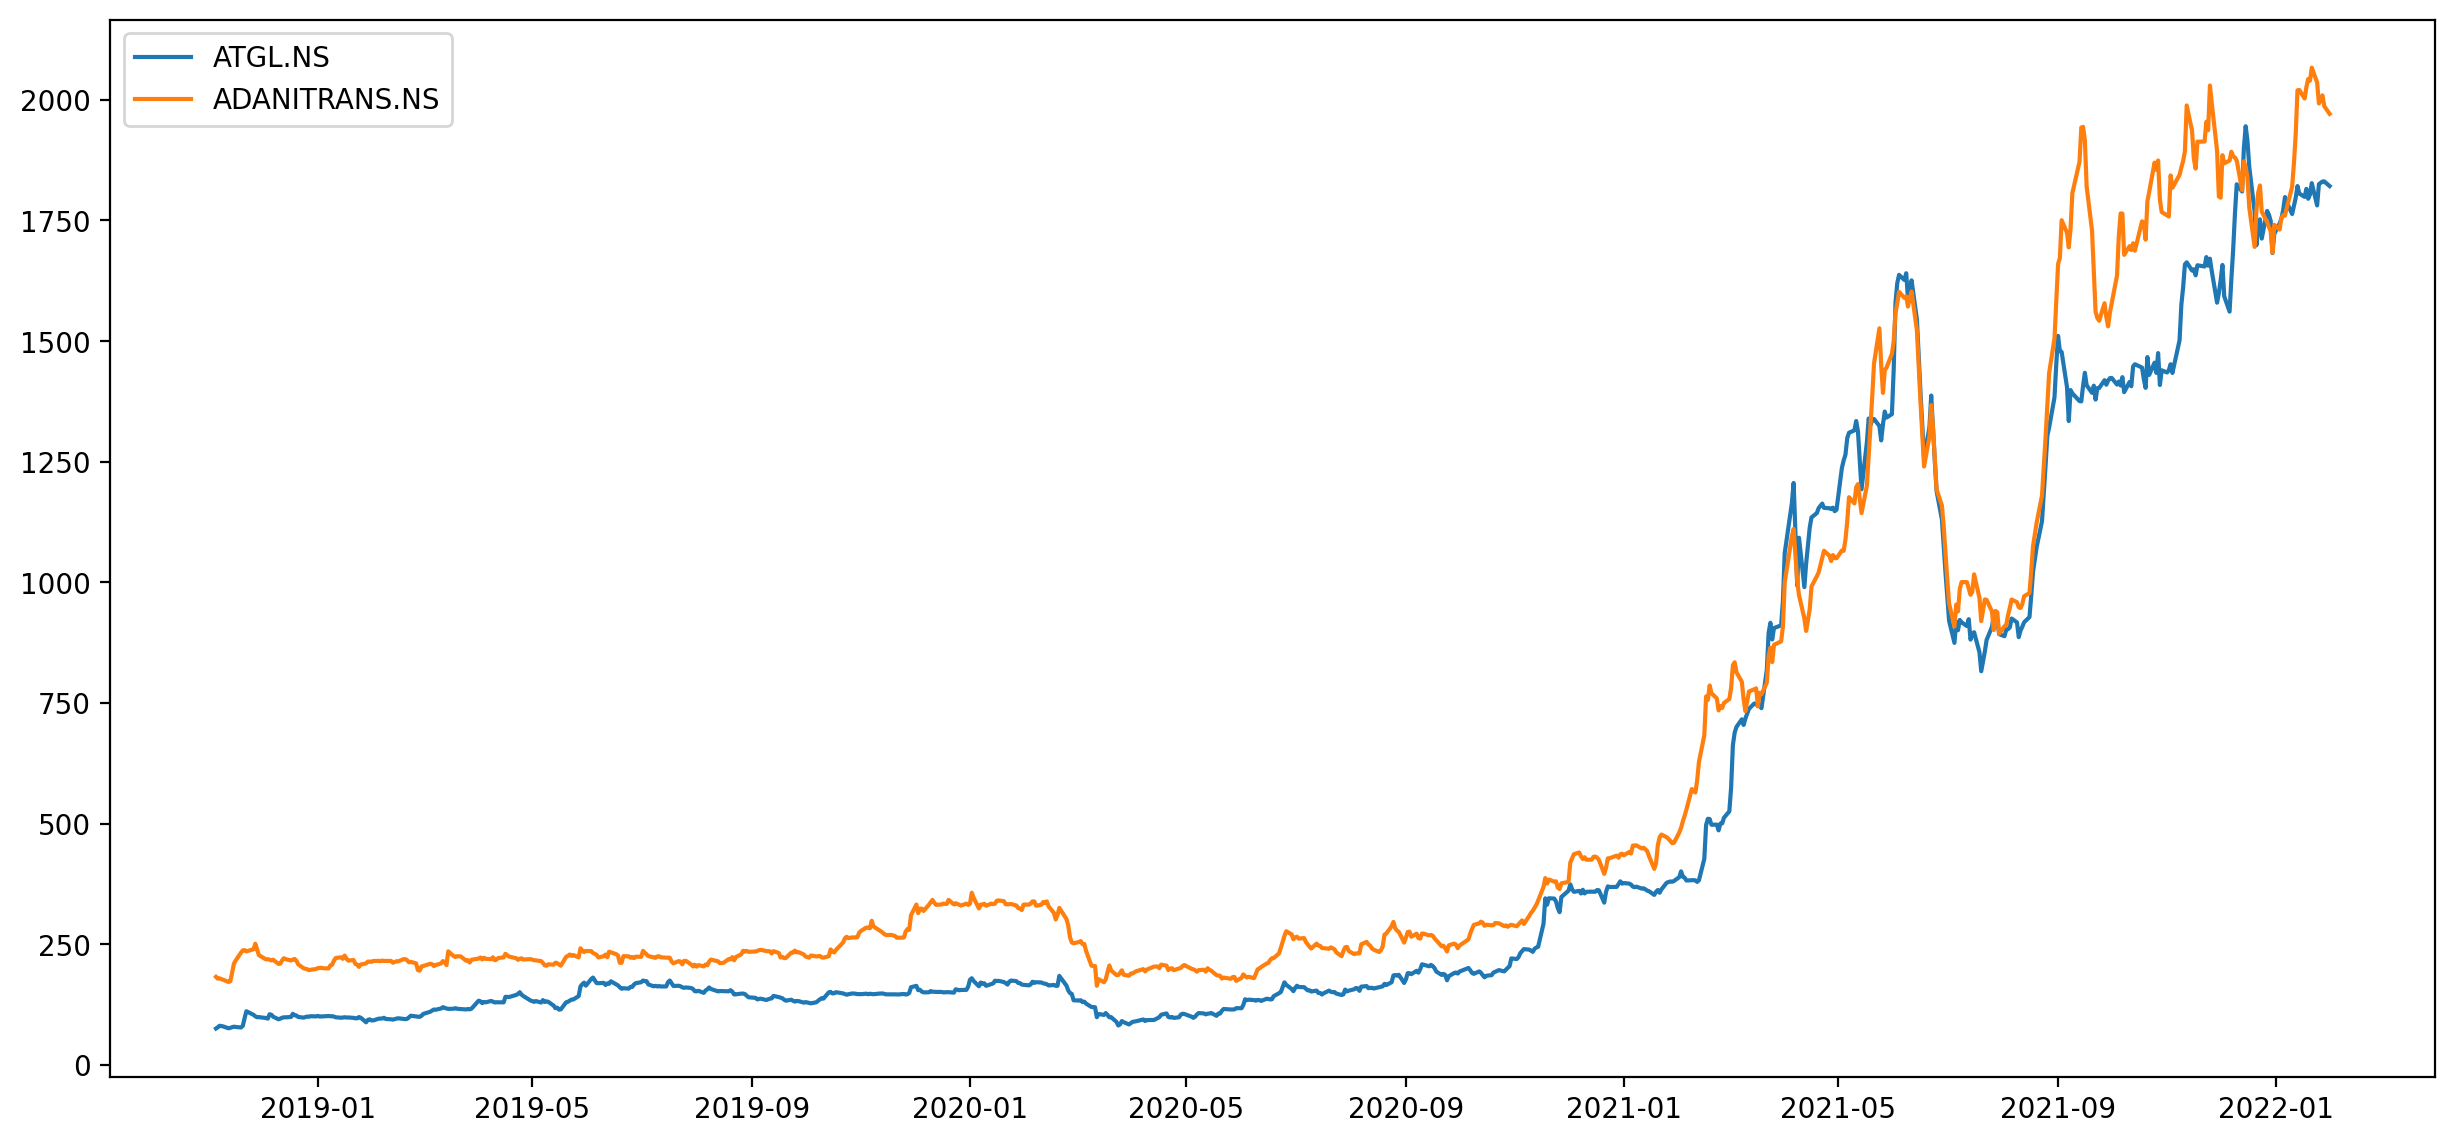

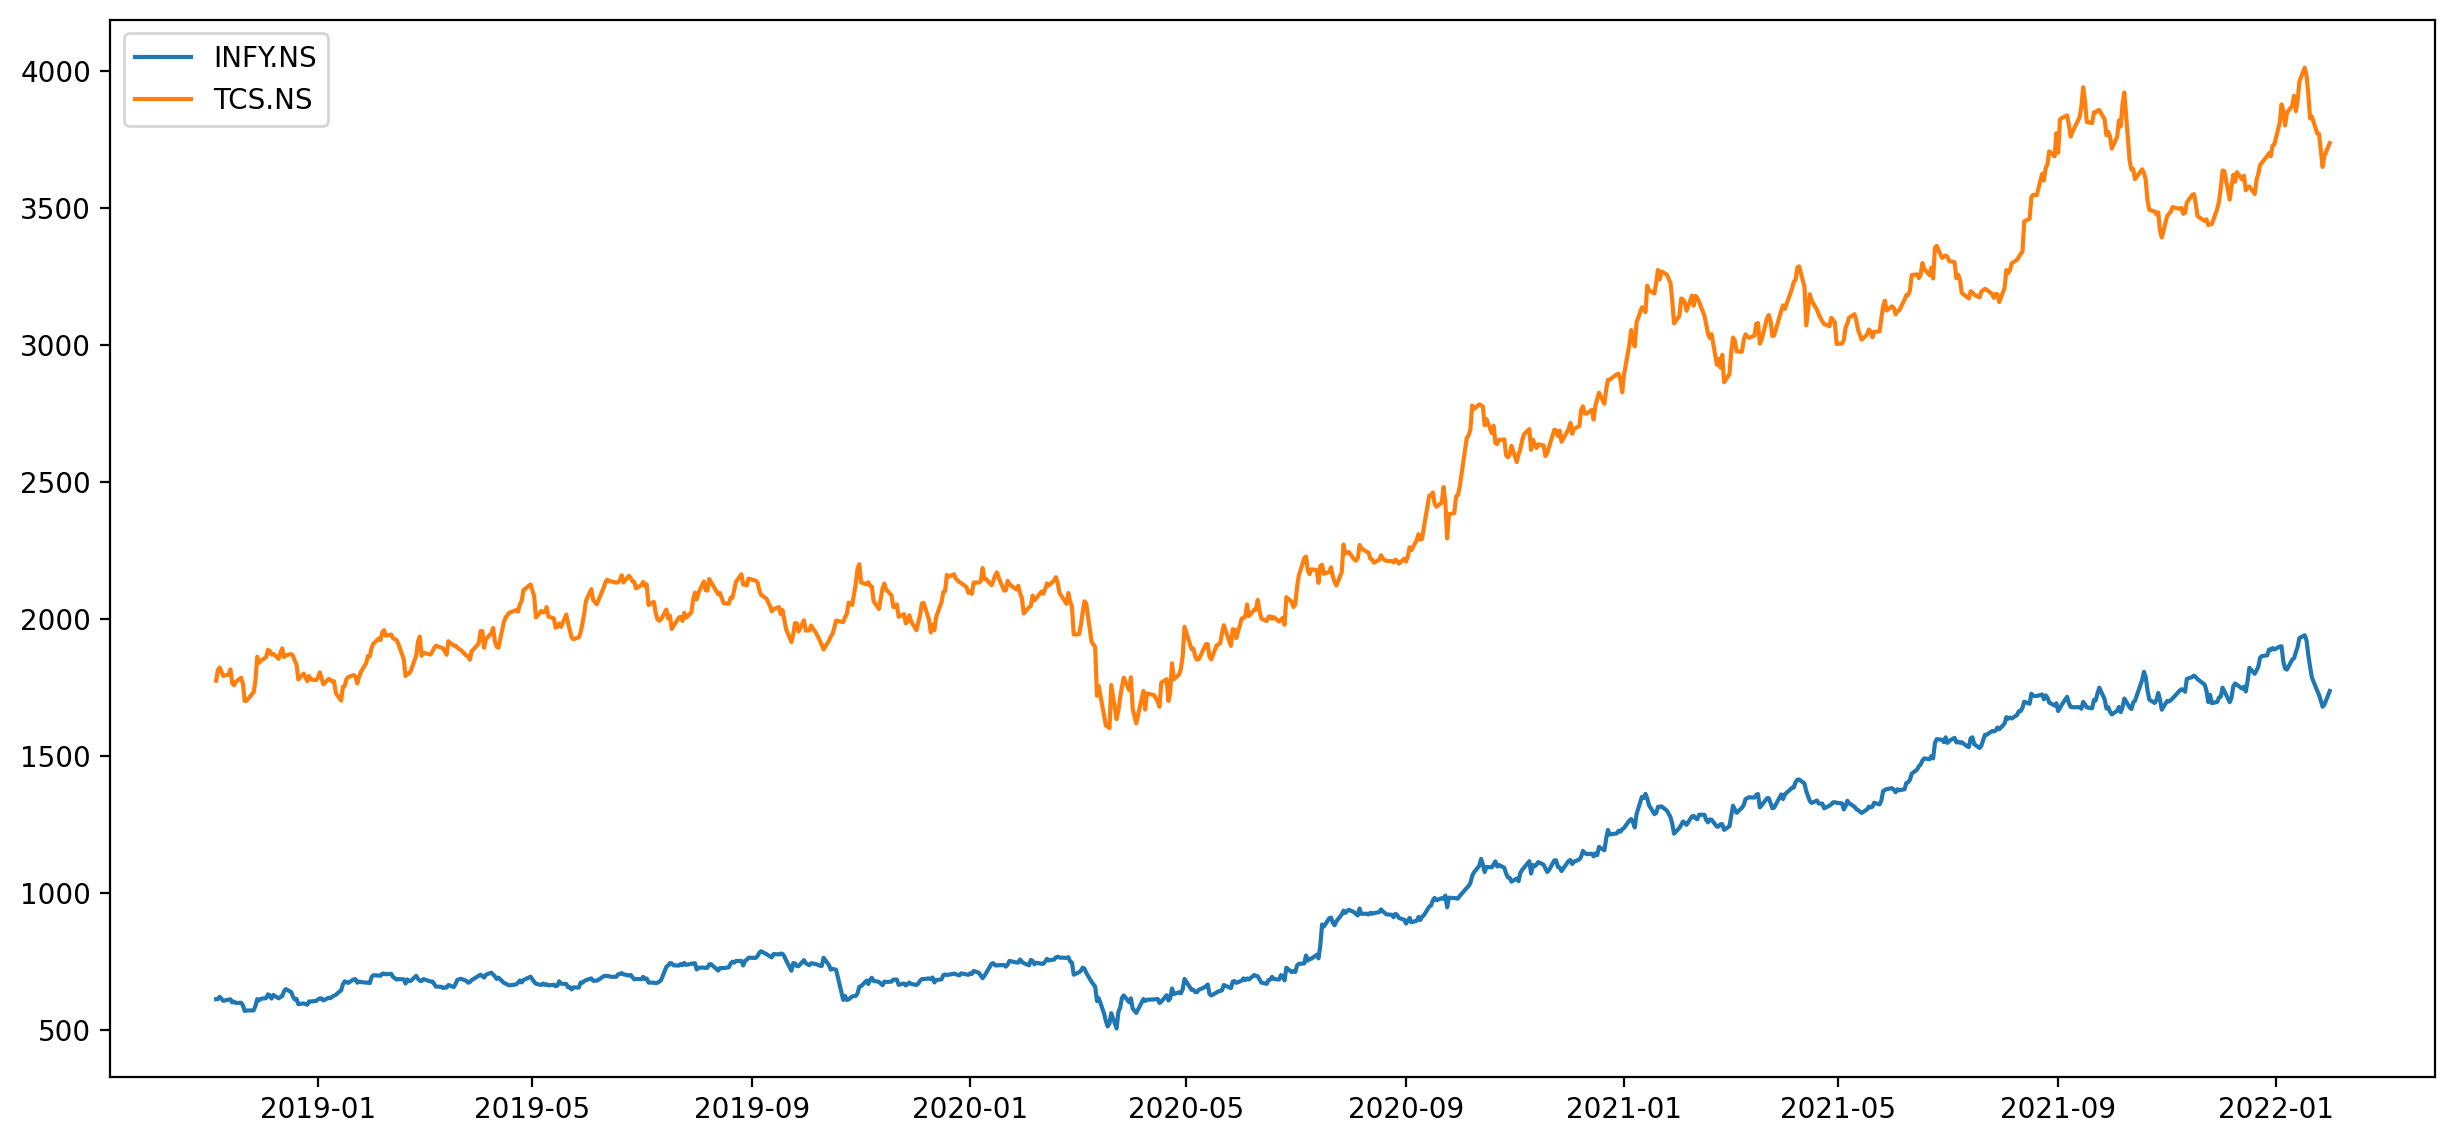

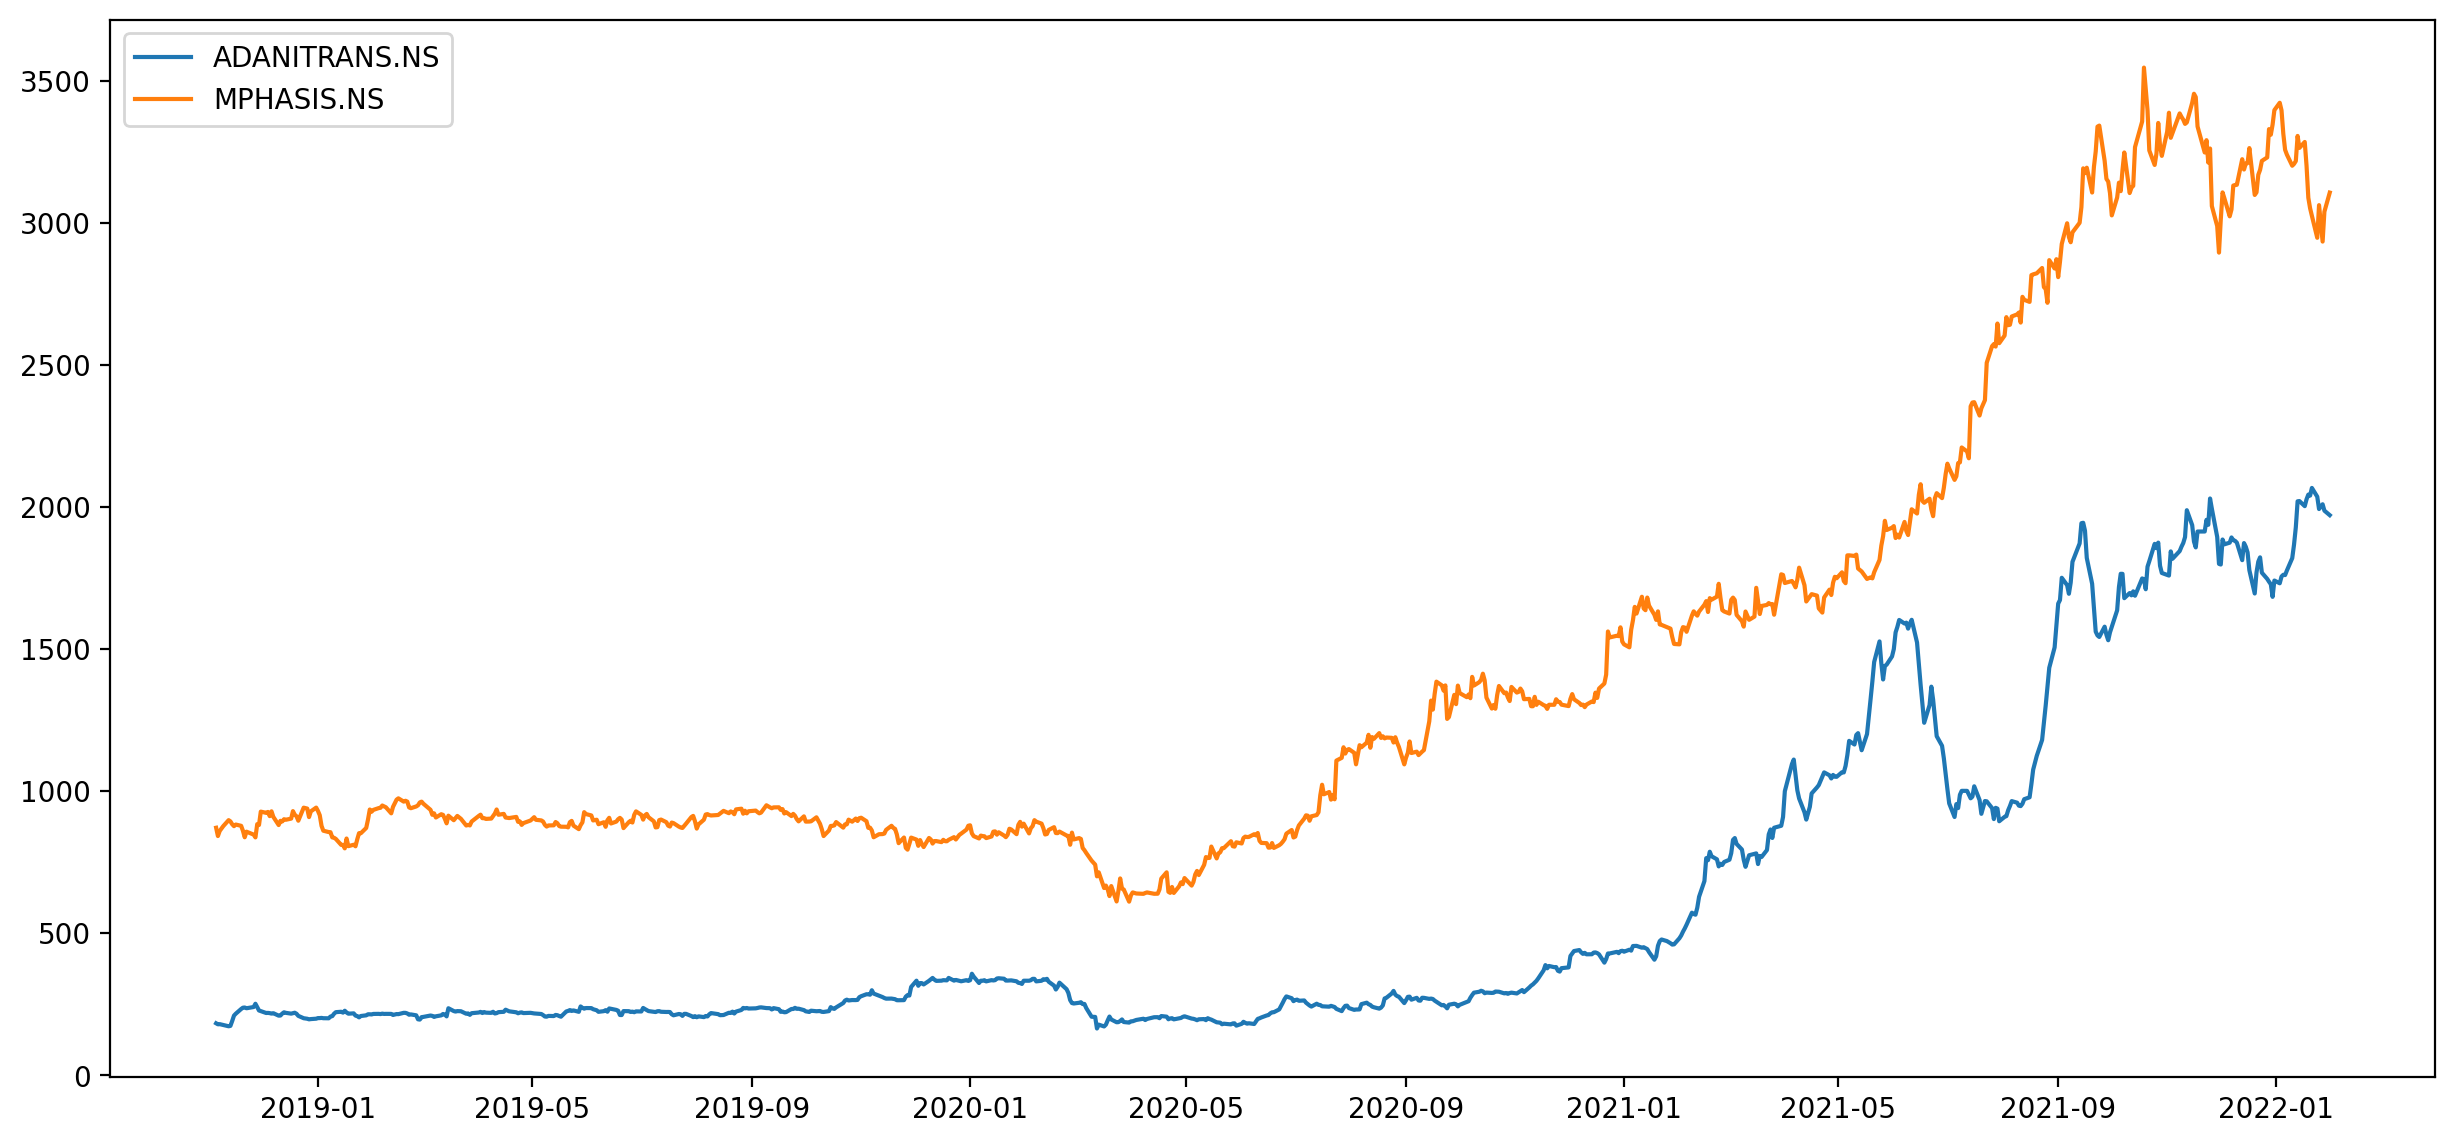

In [28]:
# Comparing Historical Adjusted Closing Prices

for pair in pairs:
    plt.figure(figsize=(15,7), dpi=200)
    S1 = d[pair[0]]
    plt.plot(S1, label = f"{pair[0]}")
    S2 = d[pair[1]]
    plt.plot(S2, label = f"{pair[1]}")
    plt.legend()

0.000573504714188034


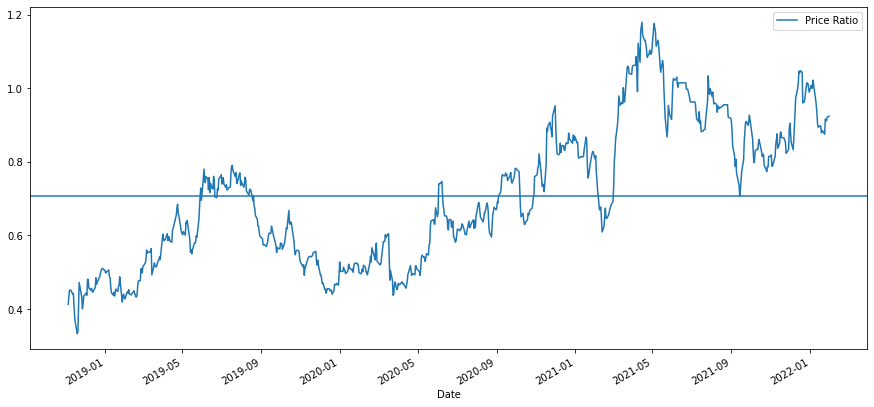

In [29]:
# We choose the pair ATGL and ADANITRANS because the spread between the two has greater no. of intersection implying more trading opportunities
S1 = d['ATGL.NS']
S2 = d['ADANITRANS.NS']
score, pvalue, _ = coint(S1, S2)
print(pvalue)
ratios = S1 / S2
ratios.plot(figsize=(15,7))
plt.axhline(ratios.mean())
plt.legend(['Price Ratio'])
plt.show()

In [30]:
def zscore(series):
    return (series - series.mean()) / np.std(series)


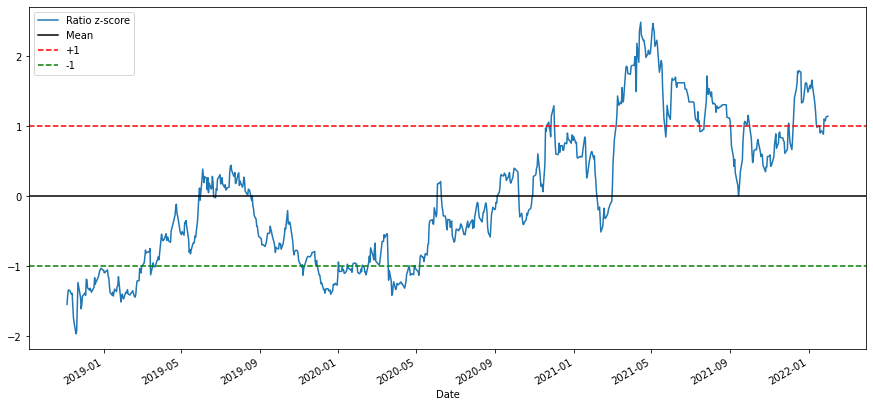

In [31]:
zscore(ratios).plot(figsize=(15,7))
plt.axhline(zscore(ratios).mean(), color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Ratio z-score', 'Mean', '+1', '-1'])
plt.show()

In [32]:
ratios = d['ATGL.NS'] / d['ADANITRANS.NS']
print(len(ratios))
# You could split 80 / 20 for train and test, but we are not going to be backtesting in this project since the aim is to just go over the model.
# train = ratios[0:round(0.8*len(ratios))]
# test = ratios[round(0.8*len(ratios)):]


800


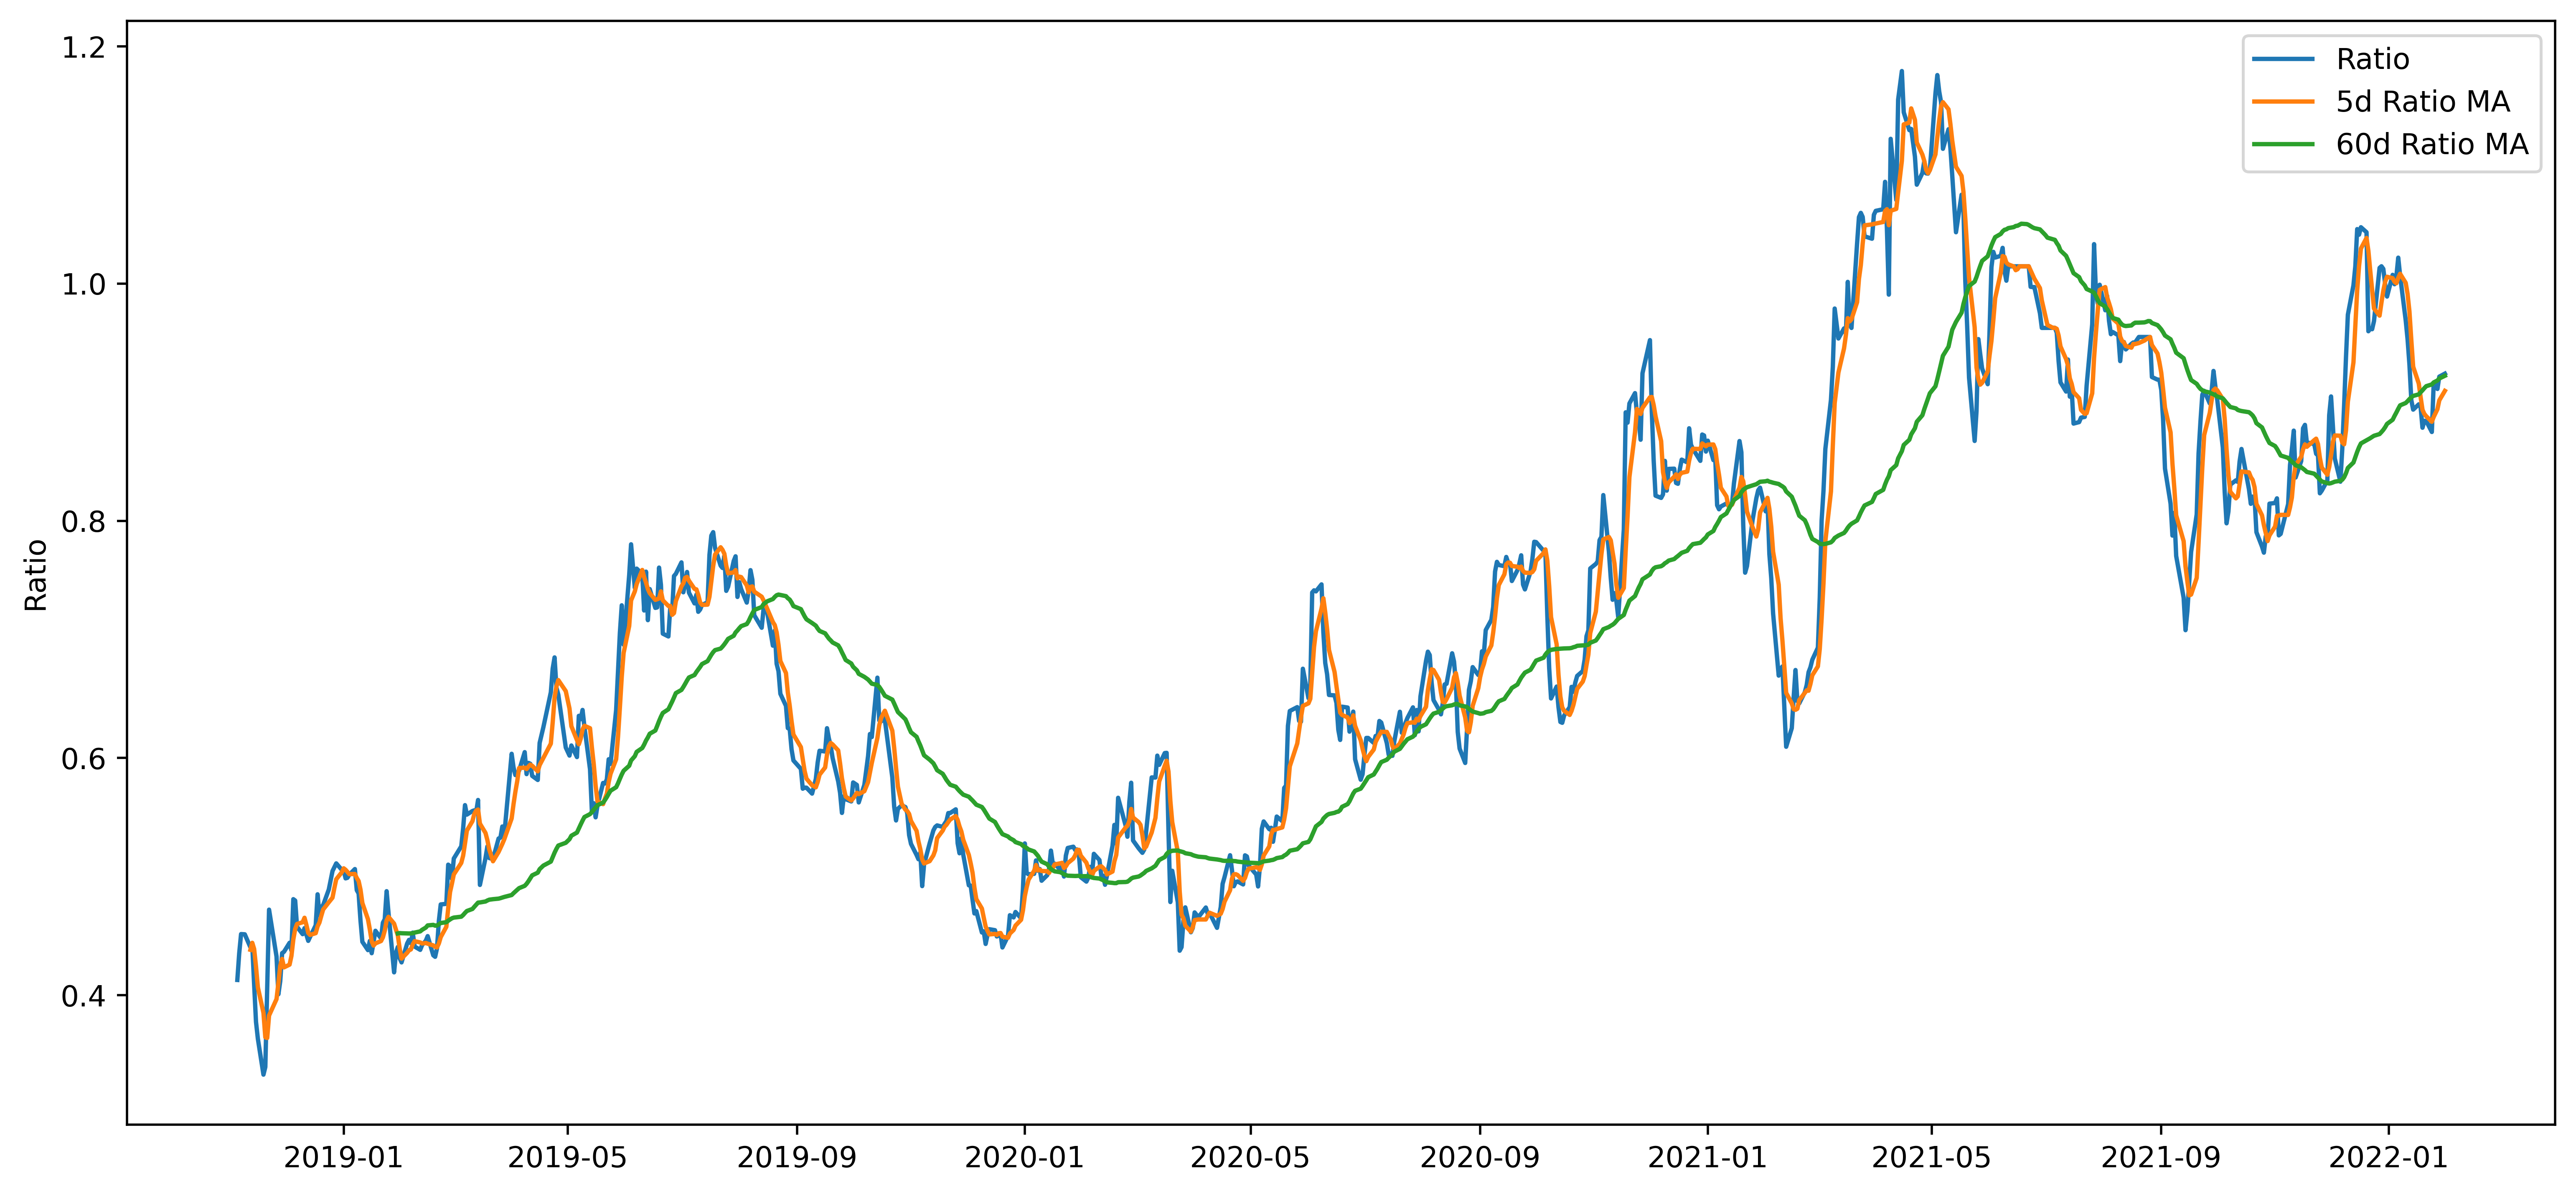

In [33]:
ratios_mavg5 = ratios.rolling(window=5,
                               center=False).mean()

ratios_mavg60 = ratios.rolling(window=60,
                               center=False).mean()

std_60 = ratios.rolling(window=60,
                        center=False).std()

zscore_60_5 = (ratios_mavg5 - ratios_mavg60)/std_60
plt.figure(figsize=(15,7), dpi = 500)
plt.plot(ratios.index, ratios.values)
plt.plot(ratios_mavg5.index, ratios_mavg5.values)
plt.plot(ratios_mavg60.index, ratios_mavg60.values)

plt.legend(['Ratio','5d Ratio MA', '60d Ratio MA'])

plt.ylabel('Ratio')
plt.show()


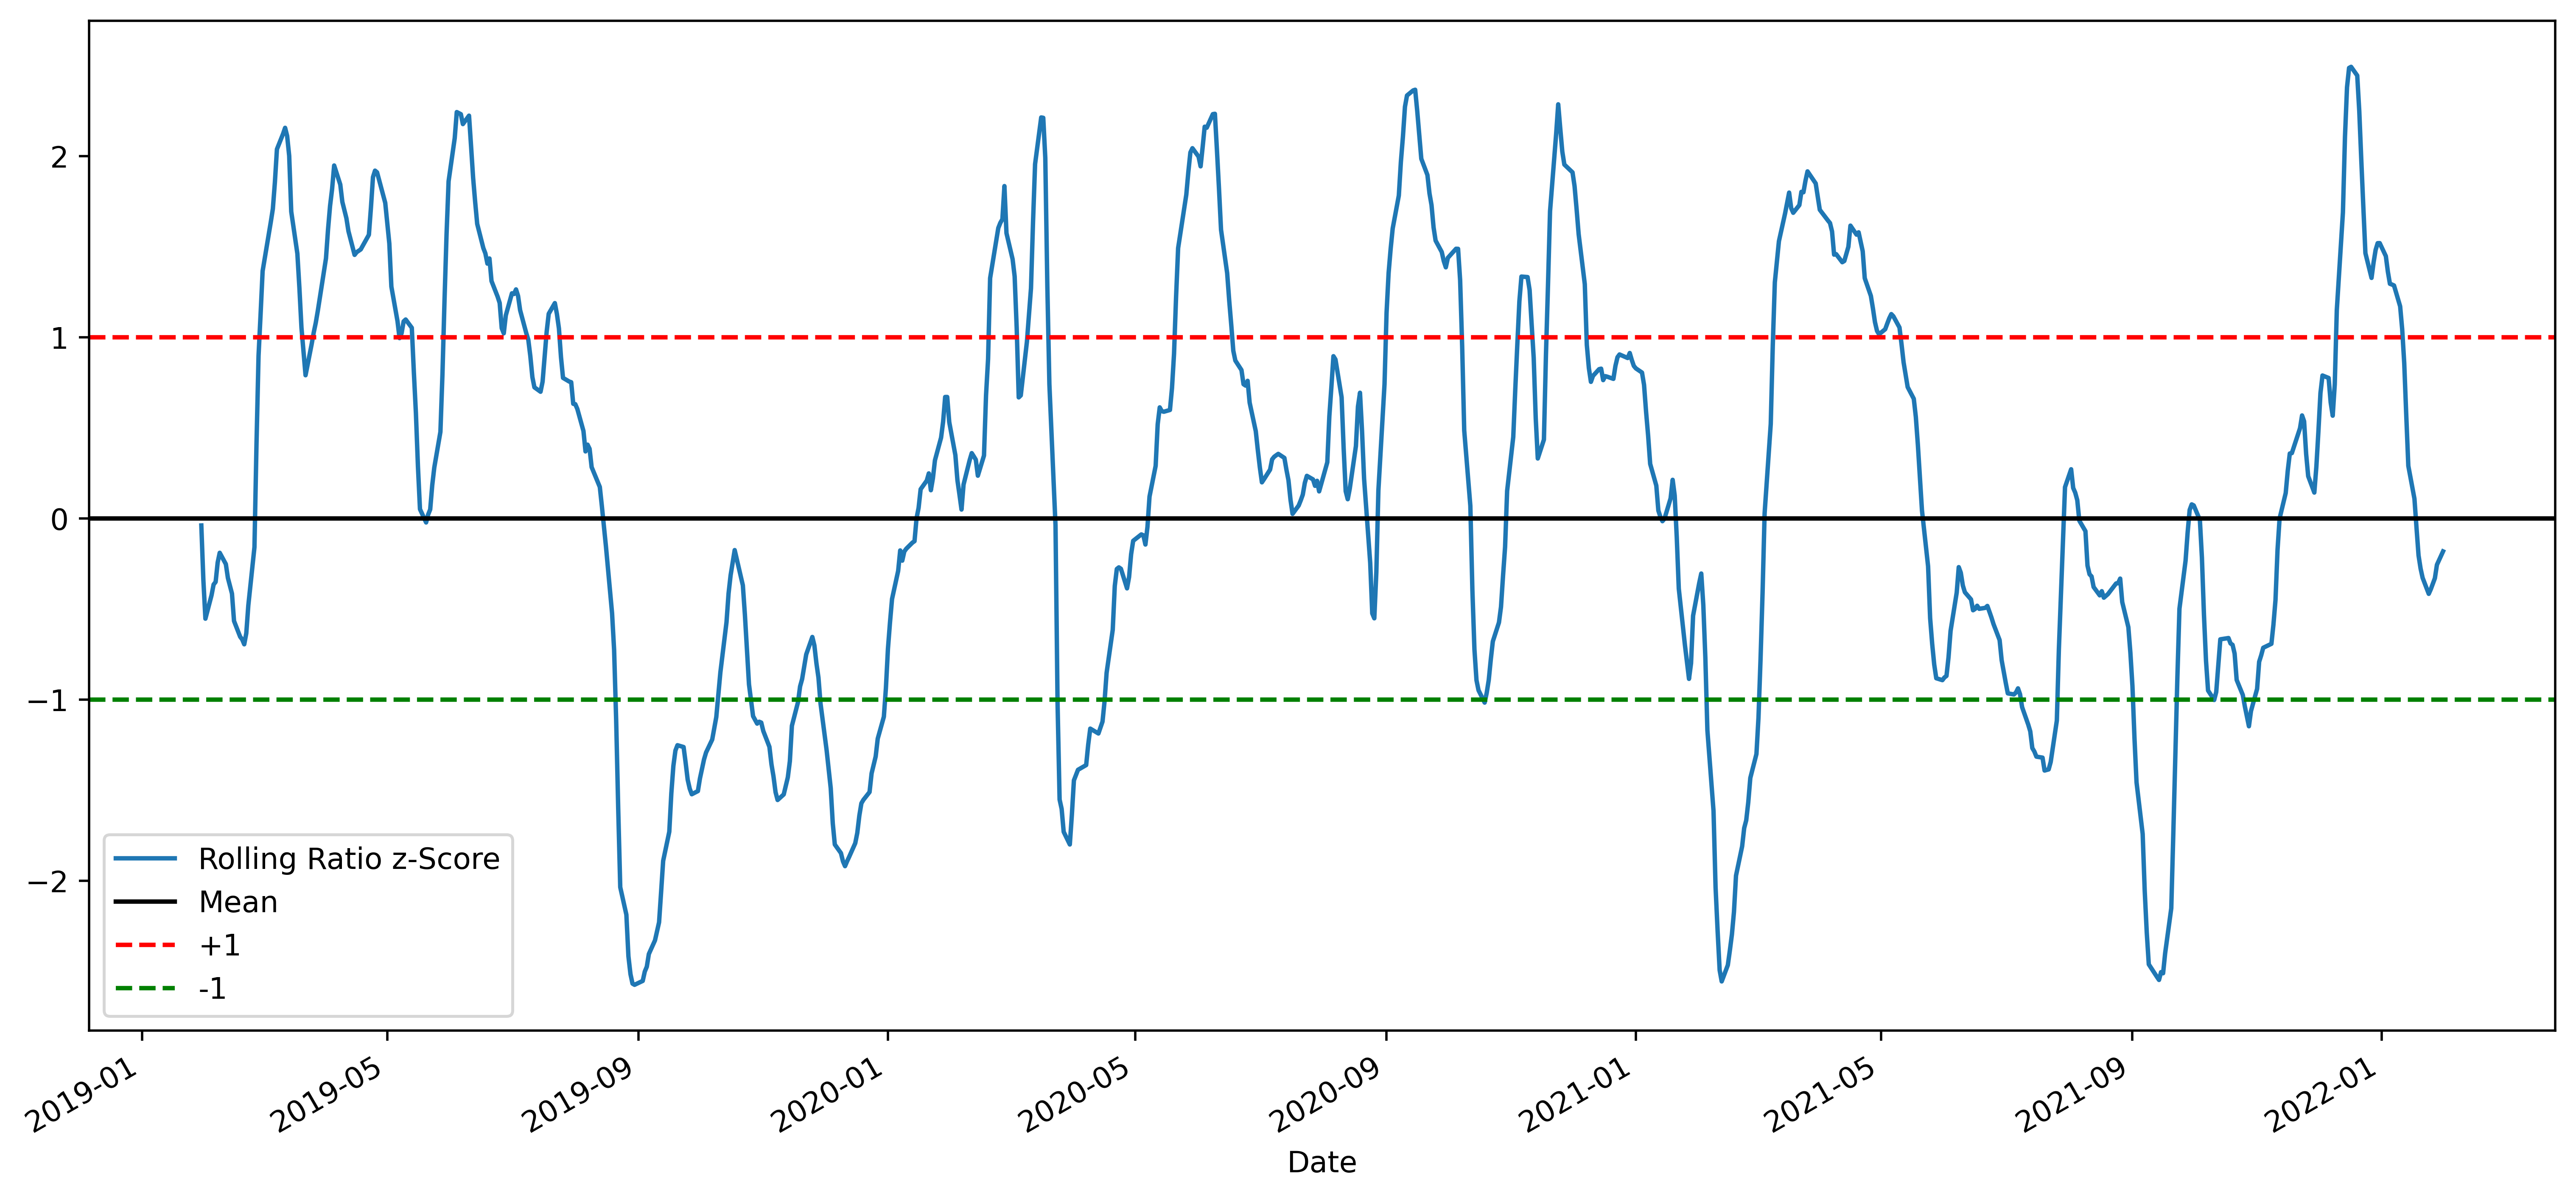

In [34]:

# Take a rolling 60 day standard deviation
std_60 = ratios.rolling(window=60,center=False).std()
std_60.name = 'std 60d'

# Compute the z score for each day
zscore_60_5 = (ratios_mavg5 - ratios_mavg60)/std_60
zscore_60_5.name = 'z-score'

plt.figure(figsize=(15,7), dpi = 500)
zscore_60_5.plot()
plt.axhline(0, color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Rolling Ratio z-Score', 'Mean', '+1', '-1'])
plt.show()


In [35]:

# Plot the ratios and buy and sell signals from z score
plt.figure(figsize=(15,7),dpi = 1000)

ratios.plot()
buy = ratios.copy()
sell = ratios.copy()
buy[zscore_60_5>-1] = 0
sell[zscore_60_5<1] = 0
buy.plot(color='g', linestyle='None', marker='^')
sell.plot(color='r', linestyle='None', marker='^')
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,ratios.min(),ratios.max()))
plt.legend(['Ratio', 'Buy Signal', 'Sell Signal'])
plt.title('Relationship ATGL.NS to ADANITRANS.NS')
plt.show()